# DLC Postprocess Library

Run after training has been performed, and at least 1 video has been analyzed

**Plan:**
1. Load config file, tracked video, and tracking results
2. Speci

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os

from PyQt5.QtWidgets import QFileDialog
from IPython.display import display, HTML

# import deeplabcut

from lib.parse_dlc_csv import parse_dlc_csv
from lib.constraints import likelihood_constrain, velocity_constrain, edge_constrain
from lib.plots import plotPerrCDF, plotVelocityCDF, plotRelEdgeLenDistr
from lib.stickman import stickman
from lib.qt_wrapper import gui_fname, gui_fpath
from lib.sampling import selectUniform

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Enter parameters for the analysis of DLC marking

In [28]:
param = {
  "EDGE_NODES"       : [[0,1], [1,2], [2,3], [3,4]],
  "NODE_MAX_V"       : [200, 200, 200, 200, 200],#[70, 70, 70, 70, 70], #70 all
  "EDGE_MIN_R"       : [0.1, 0.1, 0.1, 0.1], #[0.5, 0.5, 0.5, 0.5], #0.5
  "EDGE_MAX_R"       : [10, 10, 10, 10],#[2, 2, 2, 2], #2
  "LIKELIHOOD_THR"   : 1.0, #0.05,
  "STICKMAN_CROP_X"  : None,     # [XMIN, XMAX]
  "STICKMAN_CROP_Y"  : None,     # [YMIN, YMAX]
  "STICKMAN_OVERLAY" : True      # False
}

pwd_remote="./"
#pwd_remote = "/run/user/1000/gvfs/smb-share:server=130.60.51.15,share=neurophysiology-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/"
#param["CONF_FNAME"] = gui_fname("Select config file...", "./", "Config Files (*.yaml)")
param["AVI_FNAME"] = gui_fname("Select original video file...", pwd_remote, "Video Files (*.avi)")
tmp_pwd = os.path.dirname(param["AVI_FNAME"])
param["CSV_FNAME"] = gui_fname("Select tracking file...", tmp_pwd, "CSV Files (*.csv)")
param["REZ_FPATH"] = gui_fpath("Select result path", tmp_pwd)

#print("Using config file", param["CONF_FNAME"])
print("Using original video", param["AVI_FNAME"])
print("Using tracking file", param["CSV_FNAME"])
print("Results will be saved in", param["REZ_FPATH"])

Using original video /mnt/neurophys-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/2ndTrainingVideoSet/Mouse1Day2Irre_2018.10.23_08_58_51.avi
Using tracking file /mnt/neurophys-storage2/Sipila/aaaPDDATA/ALLDATA/TRAININGvideos/2ndTrainingVideoSet/Mouse1Day2Irre_2018.10.23_08_58_51DeepCut_resnet50_Tracking2ndRoundJun5shuffle1_896000.csv
Results will be saved in /mnt/neurophys-storage2/Sipila/aaaPDDATA/ALLDATA/Projects-DLC-Training/Tracking2ndRound-Pia-2019-06-05/results


### Analyse data, compute and plot results

Determine frames, that
* Have low confidence based on DLC self-reported analysis
* Do not fulfill node constraints (e.g. excessive velocity)
* Do not fulfill edge constraints (e.g. too large or too small edges)

In [29]:
%load_ext autoreload
%autoreload 2

from lib.constraints import likelihood_constrain, velocity_constrain, edge_constrain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Movie has 5459 frames and 5 nodes
(5459, 5) (5458, 5)
Average lengths of edges are [128.28712187 195.15966269  34.49895101  54.49573389]


,All the above combined,Edges too long or short,High velocity 1 neighbour,High velocity 2 neighbours,Low confidence
Nodes,47.0,0,47,15,0
Frames,42.0,0,42,14,0


<IPython.core.display.Javascript object>


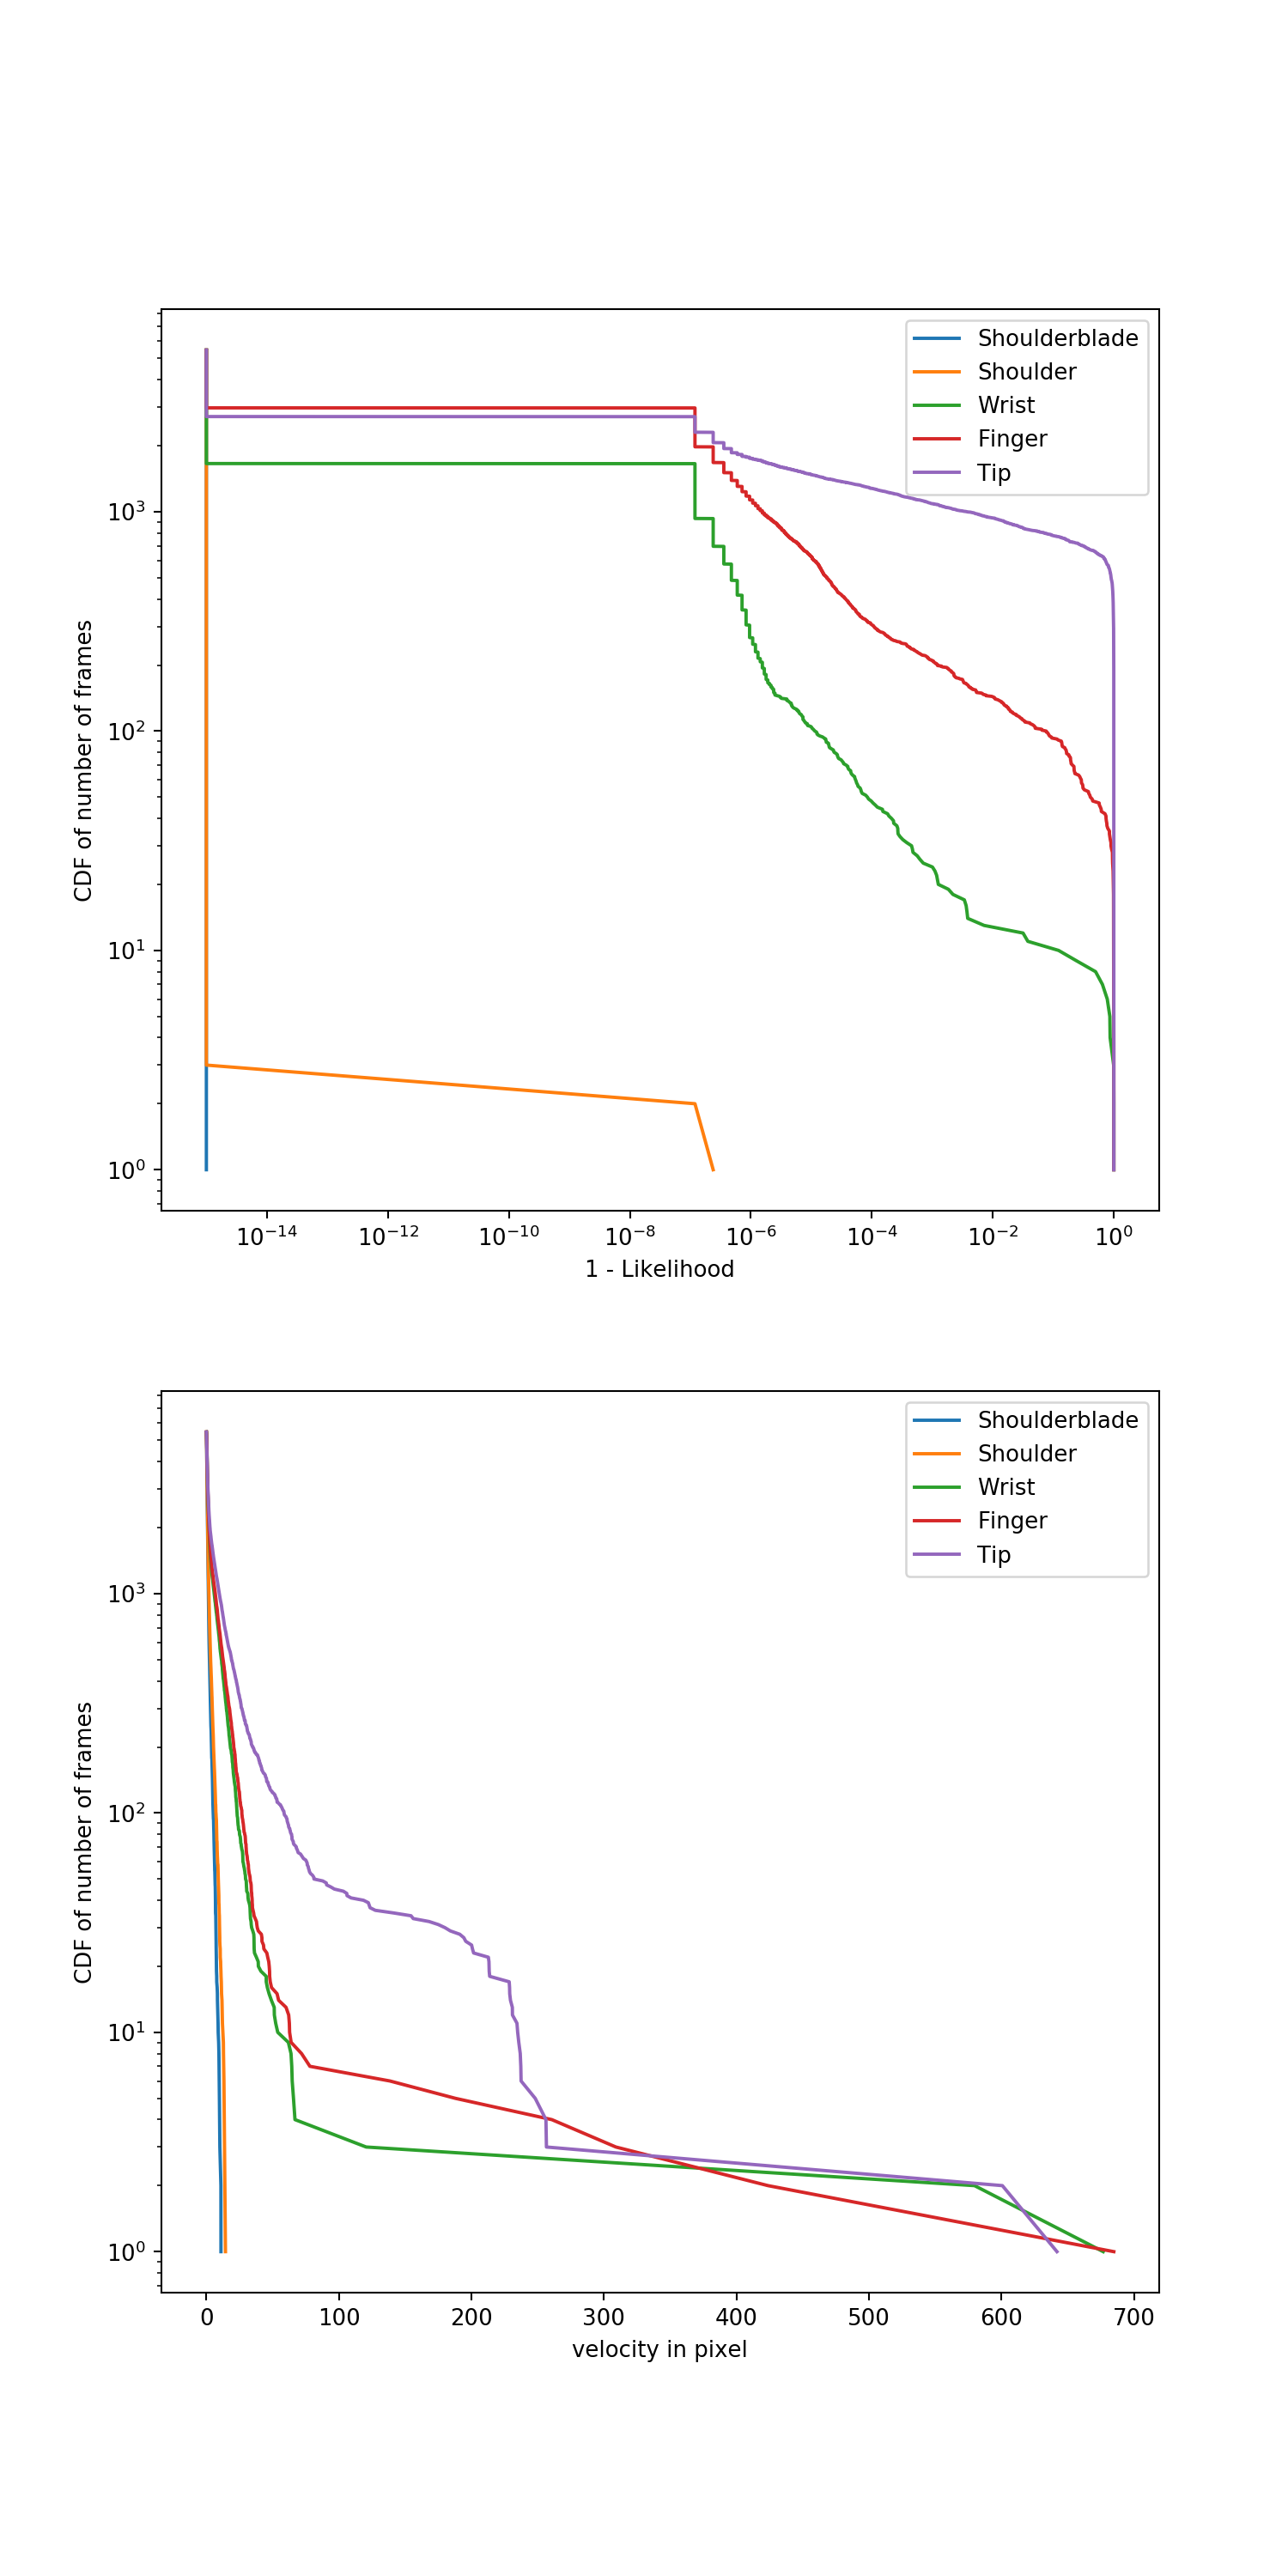

<IPython.core.display.Javascript object>


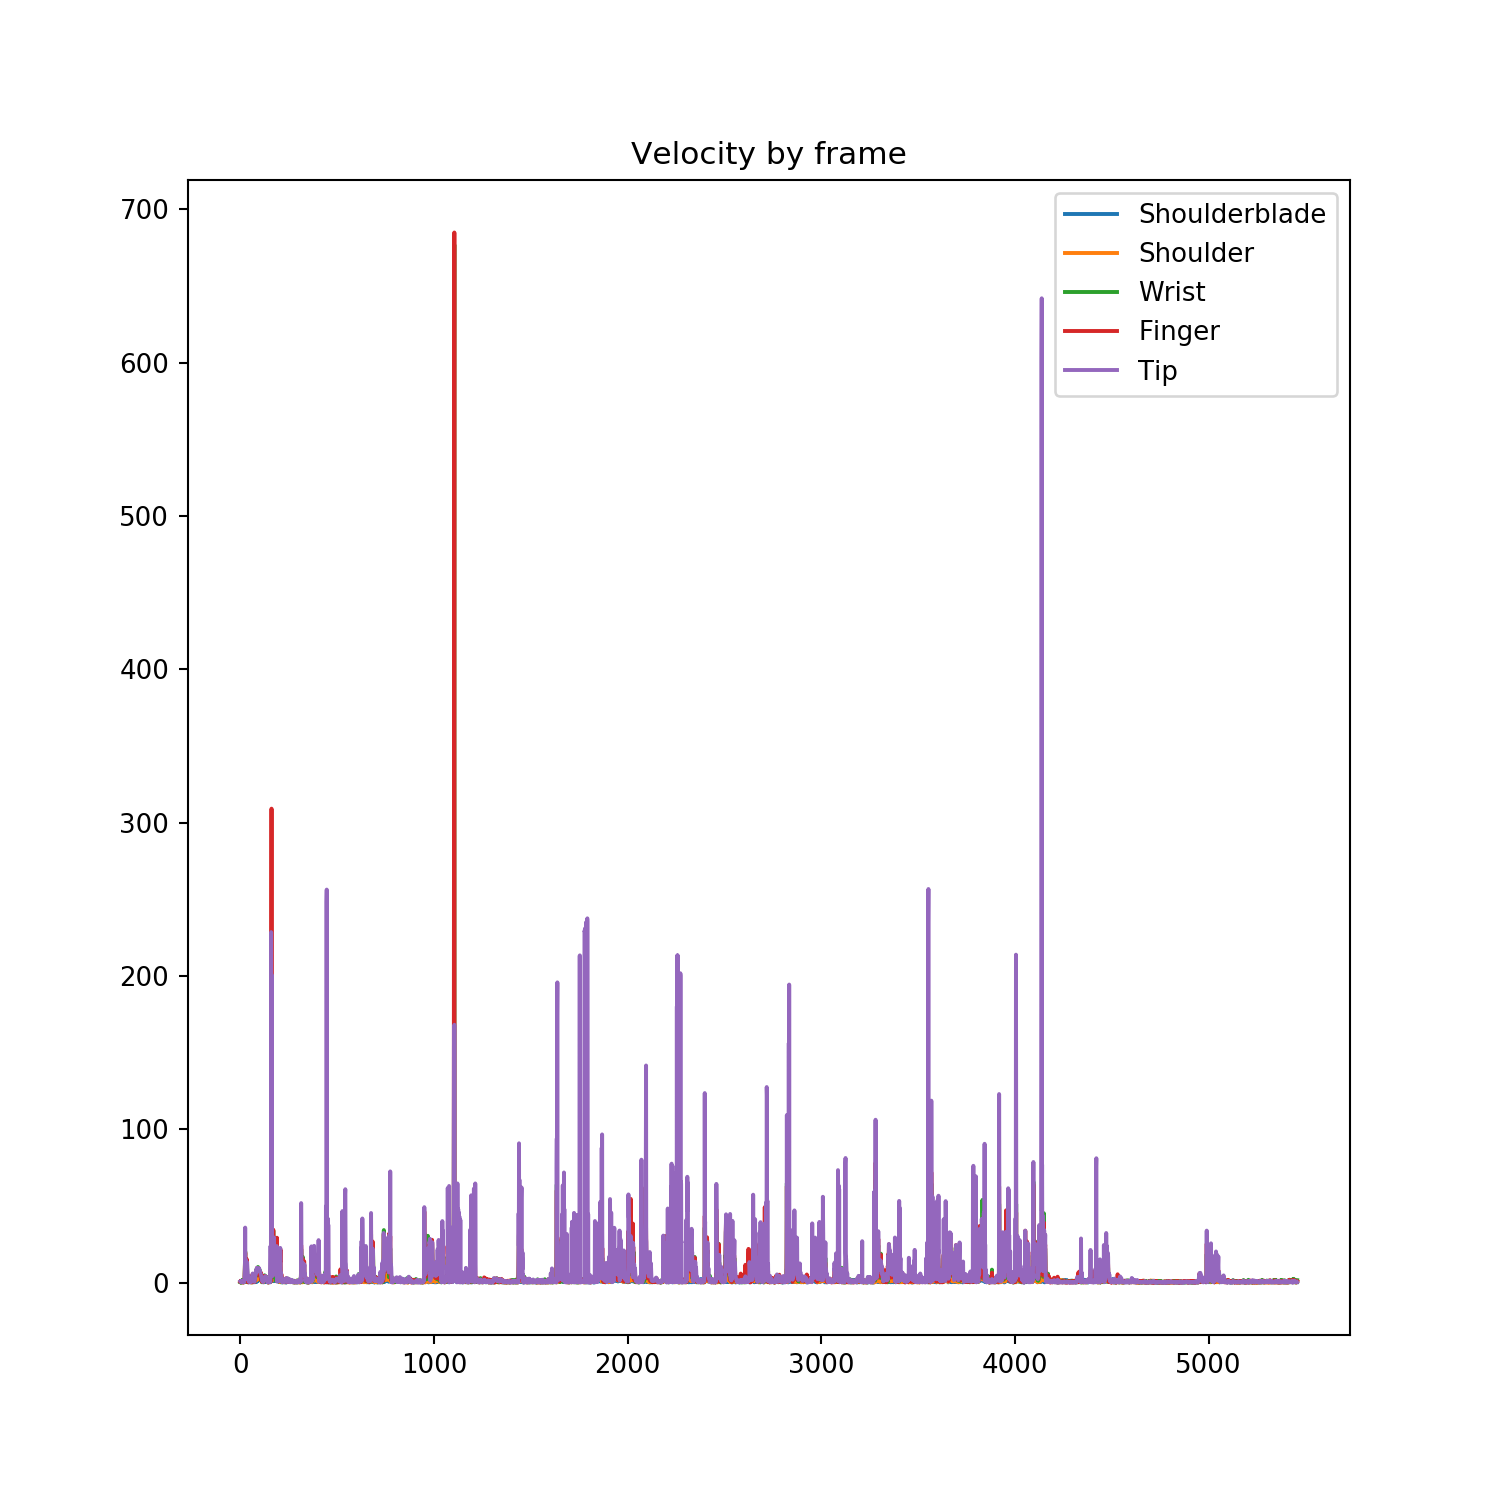

<IPython.core.display.Javascript object>


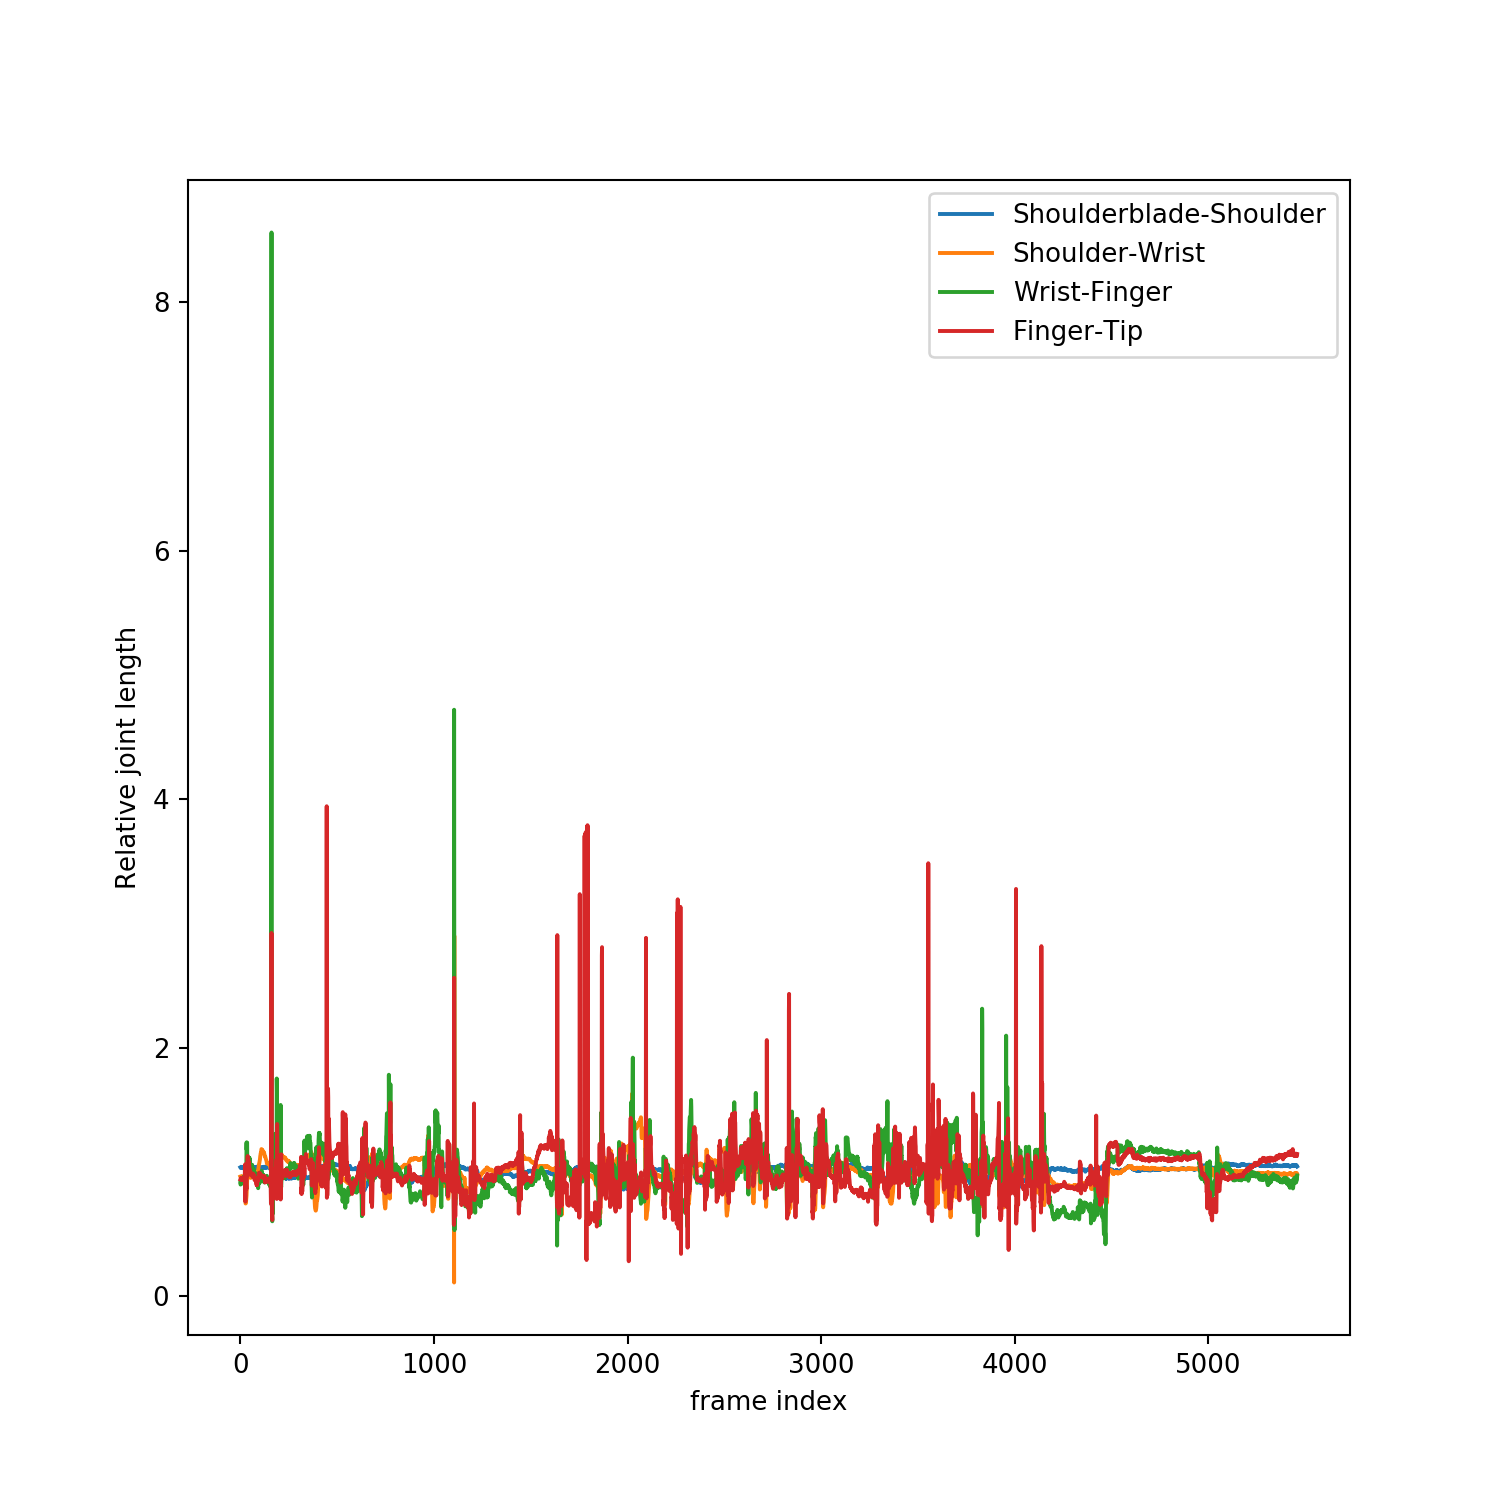

In [32]:
%matplotlib notebook
#########################
# Parse CSV file
#########################

param["NODE_NAMES"], X, Y, P = parse_dlc_csv(param["CSV_FNAME"])
nFrames, nNodes = X.shape
print("Movie has", nFrames, "frames and", nNodes, "nodes")
    
#########################
# Compute Constraints
#########################
perr, nodeLowConf = likelihood_constrain(P, param)
perr[perr==0] = 1.0e-15  # Replace all 0-errors with small numbers to allow log-plot
V, VLowConf, nodeBadV1, nodeBadV2 = velocity_constrain(X, Y, nodeLowConf, param)
edgeLength, edgeLowConf, edgeBadLength, nodeBadEdge = edge_constrain(X, Y, nodeLowConf, param)

framesLowConf    = np.sum(nodeLowConf, axis=1) > 0
framesBadV1      = np.sum(nodeBadV1, axis=1) > 0
framesBadV2      = np.sum(nodeBadV2, axis=1) > 0
framesBadEdgeLen = np.sum(edgeBadLength, axis=1) > 0
nodesBadTotal    = np.logical_or(nodeLowConf, nodeBadV1, nodeBadEdge)
framesBadTotal   = np.sum(nodesBadTotal, axis=1) > 0

print("Average lengths of edges are", np.mean(edgeLength, axis=0))
badDict = {
    "Low confidence" : (np.sum(nodeLowConf), np.sum(framesLowConf)),
    "High velocity 1 neighbour" : (np.sum(nodeBadV1), np.sum(framesBadV1)),
    "High velocity 2 neighbours" : (np.sum(nodeBadV2), np.sum(framesBadV2)),
    "Edges too long or short" : (np.sum(edgeBadLength), np.sum(framesBadEdgeLen)),
    "All the above combined" : (np.sum(nodesBadTotal), np.sum(framesBadTotal))
}
display(pd.DataFrame(badDict, index=['Nodes', 'Frames']))

#########################
# Plot Statistics
#########################
fig, ax = plt.subplots(nrows=2, figsize=(8,16))

plotPerrCDF(ax[0], perr, param)                            # Plot CDF of node confidence
plotVelocityCDF(ax[1], V, VLowConf, param)                 # Plot CDF of node velocities

fig, ax = plt.subplots(figsize=(8,8))
for iNode in range(nNodes):
    ax.plot(V[:, iNode], label=param['NODE_NAMES'][iNode])
ax.legend()
ax.set_title("Velocity by frame")


fig, ax = plt.subplots(figsize=(8,8))
plotRelEdgeLenDistr(ax, edgeLength, edgeLowConf, param) # Plot relative edge length distributions

plt.show()

### Create stickman video and write it to file

In [31]:
#########################
# Make Stickman Video
#########################

# Use velocity as node constraint for stickman plot.
nodeLowConstr = np.copy(nodeBadV1)

# Use edge length as edge constraint for stickman plot
edgeLowConstr = np.copy(edgeBadLength)

# Write stickman video
stickman(X, Y, param, nodeLowConf, nodeLowConstr, edgeLowConf, edgeLowConstr)

Writing video [5459/5459]
Done!


# Training-Only

### Decide which frames will be selected for manual marking

1. Check which constraints are present
2. Merge constraints to decide which frames are bad, possibly rank them
3. Extract numbers of frames that are bad
4. Subsample fixed amount randomly, possibly rank-biased
5. Extract actual frames, save as images 

**TODO**:
* Rank-based selection
* Clustering-based selection

In [9]:
frameIdxs = np.linspace(1, nFrames, nFrames).astype(int)
frameIdxsBad = frameIdxs[framesBadTotal]
nBadFrames = len(frameIdxsBad)

# Option 1: Select all bad frames
# selectedFrames = frameIdxsBad

# Option 2: Select fixed amount of bad frames uniformly
selectedFrames = frameIdxsBad[selectUniform(nBadFrames, 40)]

print("Selected frames are", selectedFrames)

AttributeError: module 'numpy' has no attribute 'quantile'

### Extract actual frames from the video, save them to the tracking folder

**TODO**:
* Inspect DLC outlier selection, perhaps can reuse functionality

In [ ]:
deeplabcut.extract_outlier_frames(path_config_file, [param["AVI_FNAME"]])

## Create new training dataset

In [ ]:
deeplabcut.create_training_dataset(path_config_file)

# Tracking-Only
### Post-tracking marking

**TODO**
1. Run DLC_GUI on all selected frames
2. Open resulting file, merge markings with current markings

### Finalizing

1. Mark all unconfident or unconstrained data as NAN
2. Save data to file

In [10]:
# Set all bad coordinates to NAN
X[framesBadTotal, :] = np.nan
Y[framesBadTotal, :] = np.nan

rez_fname_h5 = os.path.join(param["REZ_FPATH"], "result.h5")
print("Writing tracking data to", rez_fname_h5)
rezfile = h5py.File(rez_fname_h5, "w")
rezfile['NODE_NAMES'] = param['NODE_NAMES']
rezfile['X'] = X
rezfile['Y'] = Y
rezfile.close()

Writing tracking data to //hifosrdc09/Workspace/Neurophysiology-Storage2/Sipila/aaaPDDATA/ALLDATA/Projects-DLC-Training/Tracking2ndRound-Pia-2019-06-05/results\result.h5


TypeError: No conversion path for dtype: dtype('<U13')